## Portfolio Insurance
 - CAPM을 통한 다각화로는 비체계적 위험을 완화할 수 있으나 체계적 위험에 대해서는 대처할 수 없음
 - 위험자산과 안전자산 비중을 조정하여 위험을 통제하는 Portfolio Insurance를 실습

### 프로그래밍 환경 설정
 - 데이터 라이브러리 지정
 - 한글 관련 설정 등

In [1]:
## 사용자 정의 모듈 업데이트시마다 자동 load

%load_ext autoreload
%autoreload 2

### 공통 라이브러리 입수
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.font_manager as fm

from IPython.display import display

import os
import sys

# ### 시계열 예측 라이브러리
# from sklearn.metrics import mean_squared_error
# from pmdarima import auto_arima

### 금융 / 경제 데이터
import yfinance as yf
# from fredapi import Fred

### 금융 / 경제 함수
# import numpy_financial as npf
from pyxirr import xirr

### 통계함수
from scipy.stats import norm
from scipy.stats import jarque_bera
from scipy.optimize import minimize
# from scipy.optimize import newton
# from numpy.linalg import inv

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

### 인터넷 접속 라이브러리 (한국은행,통계청)
import requests

### 그래프 셋팅 (runtime configuration parameters (rcParams))
# plt.rcParams['font.family'] ='Malgun Gothic'  # 한글 깨짐 방지
# plt.rcParams['axes.unicode_minus'] = False    # 마이너스 부호 깨짐 방지
plt.style.use('ggplot')                       # 그래프 스타일

### 사용자 정의 모듈 import
import PM_Tool_Kit_2025 as pk

### CPPI(TPPI) 계산 함수 작성

In [2]:
### CPPI 실행을 위한 함수 작성

def pf_insurance(rtn,freq,init_value,multiplier,rf,max_loss_ratio,type = 'CPPI'):

  # CPPI 백테스팅 결과 저장용 데이터프레임
  cppi_bt = pd.DataFrame(columns=['rtn_risky','rtn_safe','floor_value', 'cushion', 'risky_wgt', 'safe_wgt',
                                  'risky_value', 'safe_value', 'pf_value'], index=rtn.index)

  # 수익률 행렬에 무위험 수익률 추가
  rtn_ = rtn
  rtn_.columns = ['risky_asset']
  if freq == 'D':
    rtn_['safe_asset'] = rf / 252
  if freq == 'W':
    rtn_['safe_asset'] = rf / 52
  if freq == 'M':
    rtn_['safe_asset'] = rf / 12

  # 최소 보장 가치
  floor_value = init_value * (1 - max_loss_ratio)

  # TPPI 초기치
  peak = init_value

  # CPPI 전략 계산
  for i, date in enumerate(rtn.index):

      if i == 0:
          # 초기값 설정
          pf_value = init_value
      else:
          pf_value = cppi_bt.iloc[i-1]['pf_value']  # 이전 포트폴리오 가치

      # 위험자산과 안전자산 수익률
      rtn_risky = rtn_.loc[date, 'risky_asset']
      rtn_safe = rtn_.loc[date, 'safe_asset']

      # 쿠션 계산
      cushion = (pf_value - floor_value) / pf_value
      risky_wgt = multiplier * cushion
      risky_wgt = min(max(risky_wgt, 0), 1)  # 위험 자산 비중을 0~1 사이로 제한
      safe_wgt = 1 - risky_wgt

      # 위험 및 안전 자산 가치 계산
      risky_value = pf_value * risky_wgt * (1 + rtn_risky)
      safe_value = pf_value * safe_wgt * (1 + rtn_safe)
      new_pf_value = risky_value + safe_value

      if type == 'TPPI':
        # TPPI : 과거 최대치의 x% 이상을 보전하도록 설계
        peak = np.maximum(peak, new_pf_value)
        floor_value = peak*(1-max_loss_ratio)

      # 결과 저장
      cppi_bt.loc[date] = [rtn_risky,rtn_safe,floor_value, cushion, risky_wgt, safe_wgt, risky_value, safe_value, new_pf_value]

  return cppi_bt

### 위험자산 수익률 데이터 및 파라메터 셋팅

In [3]:
stdt = '2000-01-01'
ltdt = '2024-12-31'

stk_data = yf.download(['^GSPC'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)

stk_data = stk_data.tz_localize(None)['Adj Close']
stk_data.columns = ['SP500']
rtn_w = pk.get_return(stk_data,freq = 'W')

### CPPI 전략 파라메터

init_value = 100000    # 초기 자산
multiplier = 4        # 승수, 위험 자산에 대한 민감도를 조절
rf = 0.05 # 무위험 수익률
max_loss_ratio = 0.1  # 최대손실률

### 수익률 시계열
rtn = pd.DataFrame(rtn_w['SP500'])


[*********************100%***********************]  1 of 1 completed


In [4]:
### 실행

cppi_result = pf_insurance(rtn = rtn,
                           freq = 'W',
                           init_value = 100000,
                           multiplier = 4,
                           rf = 0.05,
                           max_loss_ratio = 0.1,
                           type = 'CPPI')


In [ ]:
### 함수를 직접 코딩


### 실행결과

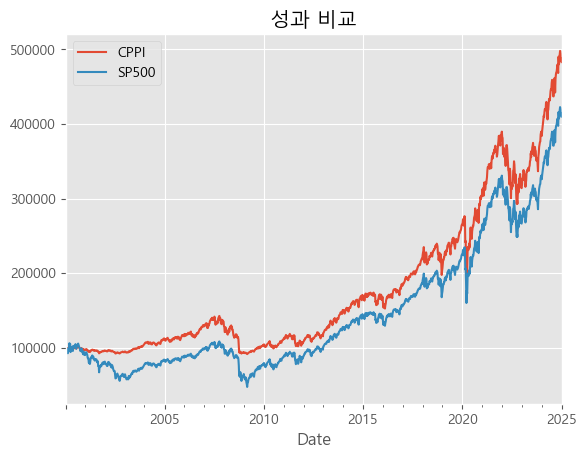

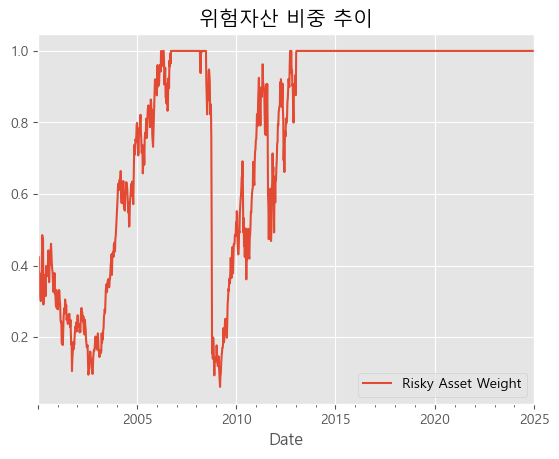

In [5]:
### 그래프

cppi_result['pf_value'].plot(label = 'CPPI')
risky_value = init_value * (1+cppi_result['rtn_risky']).cumprod()
risky_value.plot(label = 'SP500')
plt.legend()
plt.title('성과 비교')
plt.show()

cppi_result['risky_wgt'].plot(label = 'Risky Asset Weight')
plt.legend()
plt.title('위험자산 비중 추이')
plt.show()


In [6]:
display(pk.fs_desc(cppi_result['pf_value'],'W',rf = 0.03))
display(pk.fs_desc(risky_value,'W',rf = 0.03))

,pf_value
Annual_Rtn,0.064551
Annual_Std,0.131968
Normal VaR,-0.028729
C-F VaR,-0.030135
Historical VaR,-0.027391
MDD,-0.358657
Sharpe,0.261811


,rtn_risky
Annual_Rtn,0.057215
Annual_Std,0.177868
Normal VaR,-0.039194
C-F VaR,-0.041547
Historical VaR,-0.038977
MDD,-0.562441
Sharpe,0.153008


### KOSPI에 적용시

In [7]:
stk_data = yf.download(['^KS11'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)  # Yahoo finance는 end시점 전일까지의 데이터를 가져오기 떄문에 하루를 더해 줌

stk_data = stk_data.tz_localize(None)['Adj Close']
stk_data.columns = ['KOSPI']
rtn_w = pk.get_return(stk_data,freq = 'W')

### CPPI 전략 파라메터

init_value = 100000    # 초기 자산
multiplier = 4        # 승수, 위험 자산에 대한 민감도를 조절
rf = 0.05 # 무위험 수익률
max_loss_ratio = 0.1  # 최대손실률

### 수익률 시계열
rtn = pd.DataFrame(rtn_w['KOSPI'].loc['2013':])

cppi_result = pf_insurance(rtn = rtn,
                           freq = 'W',
                           init_value = 100000,
                           multiplier = 4,
                           rf = 0.05,
                           max_loss_ratio = 0.1,
                           type = 'TPPI')


[*********************100%***********************]  1 of 1 completed


### 실행결과

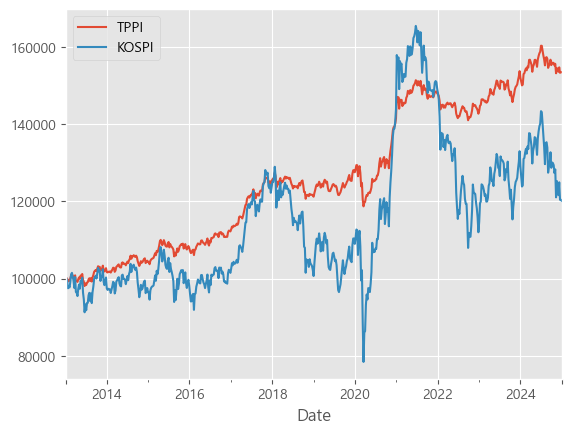

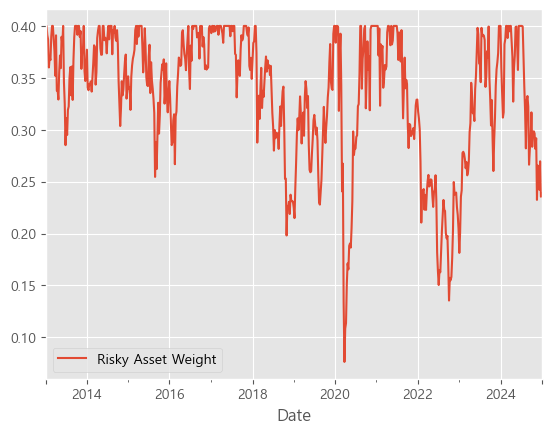

In [8]:
cppi_result['pf_value'].plot(label = 'TPPI')
risky_value = init_value * (1+cppi_result['rtn_risky']).cumprod()
risky_value.plot(label = 'KOSPI')
plt.legend()
plt.show()

cppi_result['risky_wgt'].plot(label = 'Risky Asset Weight')
plt.legend()
plt.show()

In [9]:
display(pk.fs_desc(cppi_result['pf_value'],'W',rf = 0.05))
display(pk.fs_desc(risky_value,'W',rf = 0.05))

,pf_value
Annual_Rtn,0.035883
Annual_Std,0.049496
Normal VaR,-0.010588
C-F VaR,-0.011265
Historical VaR,-0.011134
MDD,-0.082505
Sharpe,-0.285226


,rtn_risky
Annual_Rtn,0.01474
Annual_Std,0.158813
Normal VaR,-0.0357
C-F VaR,-0.037964
Historical VaR,-0.033356
MDD,-0.39173
Sharpe,-0.222019


### 풋옵션 매수 헷징 (Protective Put)

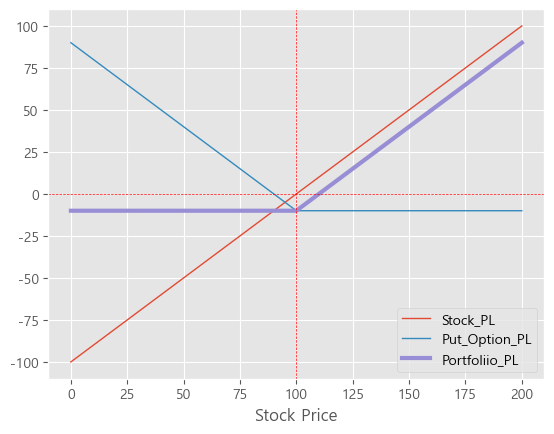

In [10]:
### 풋옵션 손익 예제

df_test = pd.DataFrame(columns=['Stock_Price', 'Stock_PL','Option_PL'])
df_test['Stock_Price'] = range(0,201)

Put_Price = 10
Put_Strike_Price = 100
Stock_Current_Price = 100

df_test['Stock_PL'] = df_test['Stock_Price'] - Stock_Current_Price
df_test['Put_Buy_PL'] = df_test['Stock_Price'].apply(lambda x: (Put_Strike_Price - Put_Price) - x if x<= Put_Strike_Price else -Put_Price )
df_test['Pf_PL'] = df_test['Stock_PL'] + df_test['Put_Buy_PL']

plt.plot(df_test['Stock_Price'], df_test['Stock_PL'], label='Stock_PL',linewidth = 1)
plt.plot(df_test['Stock_Price'], df_test['Put_Buy_PL'], label='Put_Option_PL',linewidth = 1)
plt.plot(df_test['Stock_Price'], df_test['Pf_PL'], label='Portfoliio_PL',linewidth = 3)
plt.legend()
plt.axvline(x=Put_Strike_Price, color='r', linestyle='--', label='Strike Price', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Line', linewidth=0.5)
plt.xlabel('Stock Price')
plt.show()

In [11]:
### 헷지 비용? 풋옵션 가격을 산출하고 이를 투자의 기대수익과 비교

### 옵션가격 산출

# d1 계산
def calculate_d1(S, K, r, sigma, T):
    """Calculate d1 in the Black-Scholes model."""
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

# d2 계산
def calculate_d2(d1, sigma, T):
    """Calculate d2 in the Black-Scholes model."""
    return d1 - sigma * np.sqrt(T)

# 옵션가격 산출
def black_scholes_price(S, K, r, sigma, T, option_type="call"):
    """
    Calculate the price of a European call or put option using the Black-Scholes formula.

    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        r (float): Risk-free interest rate (as a decimal).
        sigma (float): Volatility of the stock price (as a decimal).
        T (float): Time to maturity (in years).
        option_type (str): "call" for call option, "put" for put option.

    Returns:
        float: The price of the option.
    """
    d1 = calculate_d1(S, K, r, sigma, T)
    d2 = calculate_d2(d1, sigma, T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

    return price

# Parameters
S = 100  # Current stock price
K = 100  # Strike price
r = 0.03  # Risk-free interest rate (3%)
sigma = 0.2  # Volatility (20%)
T = 1  # Time to maturity (1 year)

# 풋옵션 가격
put_price = black_scholes_price(S, K, r, sigma, T, option_type="put")

# 결과 출력
print(f"Put Option Price: {put_price:.2f}\n")

# 1년후 포트폴리오의 기대값
# (Sharpe = 0.5가정)
sharpe = 0.3
init_value = 1000
invested_value = (1 - put_price / S) * init_value

er = sharpe * sigma + r
er_lb = er - sigma
er_ub = er + sigma

final_value = invested_value * (1 + er)
final_value_ub = invested_value * (1 + er_ub)
final_value_lb = invested_value * (1 + er_lb)

print(f'Expected Return : {er:.2f}')
print(f'Lower Bound : {er_lb:.2f}')
print(f'Upper Bound : {er_ub:.2f}\n')

print(f'final value : {final_value:.1f}')
print(f'Lower Bound : {final_value_lb:.1f}')
print(f'Upper Bound : {final_value_ub:.1f}')

Put Option Price: 6.46

Expected Return : 0.09
Lower Bound : -0.11
Upper Bound : 0.29

final value : 1019.6
Lower Bound : 832.5
Upper Bound : 1206.7


### 델타헷징
- 옵션 등 비선형 위험 관리에 주로 적용
- 기초자산의 매매를 통해 옵션의 수익구조 복제 가능

,Time,Stock Price,Portfolio Value,Cash Position,Stock Position,Call Option Price
0,0.000000,100.000000,0.000000,-59.870633,0.598706,9.413403
1,0.003984,101.123837,0.672848,-62.024405,0.620005,10.076798
2,0.007968,101.377708,0.830250,-62.494481,0.624642,10.213180
3,0.011952,101.839439,1.118666,-63.360333,0.633144,10.481872
4,0.015936,98.880772,-0.754595,-57.694741,0.575846,8.670824
...,...,...,...,...,...,...
247,0.984064,101.492141,-5.460351,-77.782374,0.712587,2.072879
248,0.988048,101.776815,-5.257496,-83.365563,0.767445,2.176671
249,0.992032,101.964990,-5.113082,-88.821895,0.820956,2.218685
250,0.996016,103.829128,-3.582706,-105.695052,0.983465,3.863972


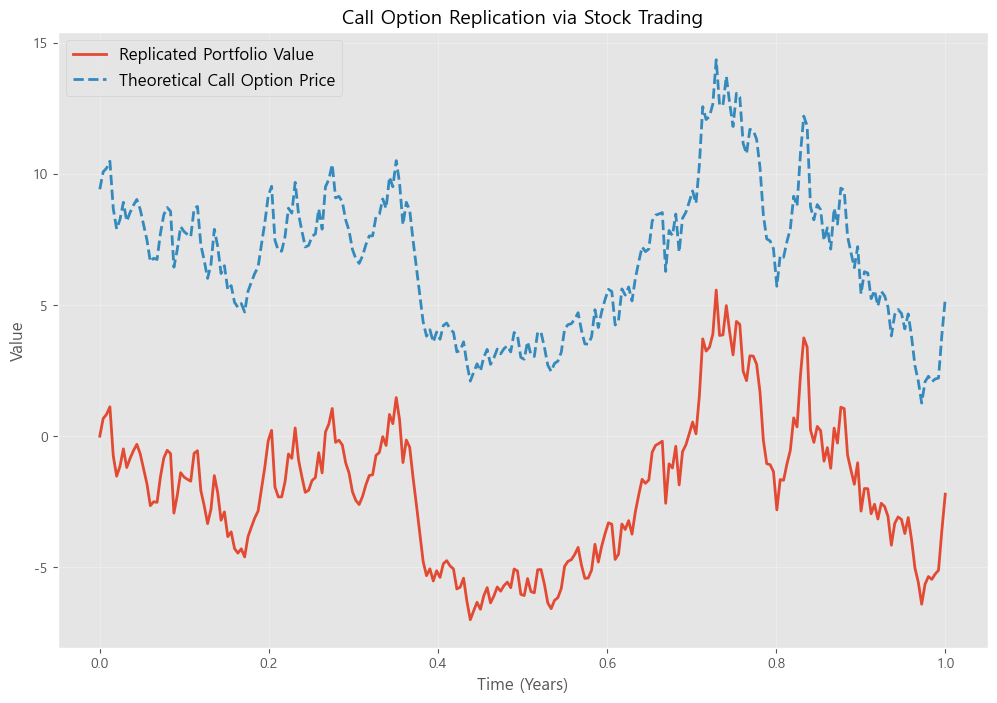

In [12]:
# Parameter 정의
S0 = 100  # 기초 주식가격
K = 100  # 행사가격
r = 0.03  # Risk-free interest rate
sigma = 0.2  # Volatility
T = 1  # Time to maturity (in years)
n_steps = 252  # 일별 헷징

# Time step
dt = T / n_steps

# 주가 시뮬레이션 (GBM)
np.random.seed(20)
stock_prices = [S0]
for _ in range(n_steps):
    Z = np.random.normal(0, 1)
    S_next = stock_prices[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    stock_prices.append(S_next)

# 블랙숄즈 모형 산출 함수
def calculate_d1(S, K, r, sigma, T):
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def calculate_d2(d1, sigma, T):
    return d1 - sigma * np.sqrt(T)

def calculate_call_delta(S, K, r, sigma, T):
    d1 = calculate_d1(S, K, r, sigma, T)
    return norm.cdf(d1)

# 델타헷징 시뮬레이션 (콜옵션 복제)
cash = 0  # 초기 Cash 포지션은 0. 주식은 차입으로 매수
stock_quantity = 0  # 초기 주식 수량
portfolio_values = []  # 주식 + 현금의 가치 (콜옵션 복제 포트폴리오)
cash_position = []  # 차입현금
stock_position = []  # 주식매입주수
call_option_prices = []  # 옵션 이론가


for i, S in enumerate(stock_prices):
    T_remaining = T - i * dt
    if T_remaining <= 0:
        break

    # 콜옵션 델타
    call_delta = calculate_call_delta(S, K, r, sigma, T_remaining)

    # 델타의 증감에 따른 주식의 매입 / 매도
    target_stock_quantity = call_delta  # 델타 계산하여 필요한 주식 수량 산출
    cash += (stock_quantity - target_stock_quantity) * S  # Cash 포지션 조정
    stock_quantity = target_stock_quantity  # 주식 포지션 조정

    # Portfolio value 산출
    portfolio_value = cash + stock_quantity * S
    cash_position.append(cash)
    stock_position.append(stock_quantity)
    portfolio_values.append(portfolio_value)

    # 옵션 이론가 산출
    call_option_prices.append(S * norm.cdf(calculate_d1(S, K, r, sigma, T_remaining)) -
                              K * np.exp(-r * T_remaining) * norm.cdf(calculate_d2(calculate_d1(S, K, r, sigma, T_remaining), sigma, T_remaining)))

# 결과 저장
df = pd.DataFrame({
    "Time": np.linspace(0, T, len(portfolio_values)),
    "Stock Price": stock_prices[:len(portfolio_values)],
    "Portfolio Value": portfolio_values,
    "Cash Position": cash_position,
    "Stock Position": stock_position,
    "Call Option Price": call_option_prices
})

display(df)

# 그래프

plt.figure(figsize=(12, 8))
plt.plot(df["Time"], df["Portfolio Value"], label="Replicated Portfolio Value", linewidth=2)
plt.plot(df["Time"], df["Call Option Price"], label="Theoretical Call Option Price", linestyle="--", linewidth=2)
plt.title("Call Option Replication via Stock Trading", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


### 수고하셨습니다